In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
#
# Pedro Tabacof
# tabacof at gmail dot com
# April 2016
#
# Bayesian uncertainty in MNIST classification
#
# Based on the MNIST Lasagne example
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

from __future__ import print_function

import sys
import os
import time

import numpy as np
import seaborn as sns

import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams

import lasagne

/home/tabacof/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using gpu device 0: GeForce GTX 660 Ti (CNMeM is disabled, CuDNN not available)
/home/tabacof/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# Experiment parameters

num_epochs = 100 # Number of epochs
batch_size = 200 # Mini batch size
weight_decay = 1e-2 # L2 regularization
dropout_p = 0.5 # Dropout probability
n_hidden = 512 # Number of neurons at hidden layer
posterior_samples = 50 # Number of posterior sample evaluations
n_in = 784 # Number of inputs (image pixels)
n_out = 2 # Number of outputs (labels)

# Bayesian approximation method
bayesian_approximation  = "dropout" # Use Gal's variational dropout method
#bayesian_approximation  = "variational" # Use Gaussian variational approximation

In [3]:

# Load MNIST dataset
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)

        data = data.reshape(-1, n_in)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    X_outside = X_train[np.where(np.logical_and(y_train != 0,  y_train != 1))]
    y_outside = y_train[np.where(np.logical_and(y_train != 0,  y_train != 1))]

    X_train = X_train[np.where(np.logical_or(y_train == 0,  y_train == 1))]
    y_train = y_train[np.where(np.logical_or(y_train == 0,  y_train == 1))]

    X_test_all = X_test
    y_test_all = y_test
    
    X_test = X_test[np.where(np.logical_or(y_test == 0,  y_test == 1))]
    y_test = y_test[np.where(np.logical_or(y_test == 0,  y_test == 1))]

    return X_train, y_train, X_test, y_test, X_outside, y_outside, X_test_all, y_test_all


# Mini batch iterator for training and testing
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Stochastic Gradient Descent with Momentum
def sgd(cost, params, lr=0.05, momentum = 0.9):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new =  acc*momentum + (1.0-momentum)*g
        updates.append([acc, acc_new])
        updates.append([p, p - acc_new * lr])
    return updates
    
# Build MLP with one hidden layer
def build_mlp(input_var=None):
    l_in = lasagne.layers.InputLayer(shape=(None, n_in),
                                     input_var=input_var)

    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units=512,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=dropout_p)

    l_out = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return l_out
       
# Weight initialization helper function
def init(n_in, n_out, name):
    values = np.asarray(np.random.uniform(
        low=-np.sqrt(6. / (n_in + n_out)),
        high=np.sqrt(6. / (n_in + n_out)),
        size=(n_in, n_out)), 
        dtype=theano.config.floatX)

    return theano.shared(value=values, name=name, borrow=True)
   

In [4]:
# Load the dataset
print("Loading data...")
X_train, y_train, X_test, y_test, X_outside, y_outside, X_test_all, y_test_all = load_dataset()

# Prepare Theano variables for inputs and targets
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

if bayesian_approximation == "dropout":
    # MLP with one hidden layer
    network = build_mlp(input_var)
    
    # Softmax output
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    
    # L2 regularization (weight decay)
    weightsl2 = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2)
    loss += weight_decay*weightsl2
    
    # SGD training
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.momentum(loss, params, learning_rate=0.01, momentum=0.9)
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Test functions
    test_prediction = lasagne.layers.get_output(network, deterministic=False)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
    test_loss = test_loss.mean()
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var), dtype=theano.config.floatX)
    test_fn = theano.function([input_var, target_var], [loss, test_prediction, test_acc])

    # Probability and entropy
    test_prob = theano.function([input_var], test_prediction)
    entropy = lasagne.objectives.categorical_crossentropy(test_prediction, test_prediction)
    test_entropy = theano.function([input_var], entropy)

elif bayesian_approximation == "variational":          
    # Input to hidden layer weights
    W1_mu = init(n_in, n_hidden, 'W1_mu') # Weights mean
    W1_sigma = init(n_in, n_hidden, 'W1_sigma') # Weights log standard deviation
    
    # Hidden layer to output weights
    W2_mu = init(n_hidden, n_out, 'W2_mu') # Weights mean
    W2_sigma = init(n_hidden, n_out, 'W2_sigma') # Weights log standard deviation
    
    # Biases are not random variables (for convenience)
    b1 = theano.shared(value=np.zeros((n_hidden,), dtype=theano.config.floatX), name='b1', borrow=True)
    b2 = theano.shared(value=np.zeros((n_out,),dtype=theano.config.floatX), name='b2', borrow=True)
     
    # Network parameters
    params = [W1_mu, W1_sigma, W2_mu, W2_sigma, b1, b2]
    
    # Random variables
    srng = MRG_RandomStreams(seed=234)
    rv_hidden = srng.normal((batch_size, n_in, n_hidden))   # Standard normal
    rv_output = srng.normal((batch_size, n_hidden, n_out))  # Standard normal

    # MLP
    # Hidden layer
    hidden_output = T.nnet.relu(T.dot(input_var, W1_mu + T.log(1.0+T.exp(W1_sigma))*rv_hidden) + b1)
    # Output layer    
    prediction = T.nnet.softmax(T.dot(hidden_output, W2_mu + T.log(1.0+T.exp(W2_sigma))*rv_output) + b2)
    # Prediction    
    y_pred = T.argmax(prediction, axis=1)
    
    # KL divergence between prior and posterior
    # For Gaussian prior and posterior, the formula is exact:
    DKL_hidden = (1.0 + 2.0*W1_sigma - W1_mu**2 - T.exp(2.0*W1_sigma)).sum()/2.0
    DKL_output = (1.0 + 2.0*W2_sigma - W2_mu**2 - T.exp(2.0*W2_sigma)).sum()/2.0
    
    # Negative log likelihood
    nll = -T.sum(T.log(T.clip(prediction, 0.000001, 0.999999))[T.arange(target_var.shape[0]), target_var])
    # Complete variational loss    
    loss = -(DKL_hidden + DKL_output - nll).mean()
    
    # SGD training
    updates = sgd(loss, params, 0.01)
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    
    # Test functions
    hidden_output_test = T.nnet.relu(T.dot(input_var, W1_mu) + b1)
    test_prediction = T.nnet.softmax(T.dot(hidden_output_test, W2_mu) + b2)
    test_acc = T.mean(T.eq(T.argmax(T.argmax(test_prediction, axis=1), axis = 0), target_var))
    test_fn = theano.function([input_var, target_var], [loss, test_prediction, test_acc])

    # Probability and entropy
    test_prob = theano.function([input_var], test_prediction)
    entropy = lasagne.objectives.categorical_crossentropy(test_prediction, test_prediction)
    test_entropy = theano.function([input_var], entropy)


Loading data...


In [5]:
# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err = train_fn(inputs, targets)
        train_err += err
        train_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
    inputs, targets = batch
    err, _, acc = test_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))


Starting training...
Epoch 1 of 100 took 0.205s
  training loss:		5.757188
Epoch 2 of 100 took 0.208s
  training loss:		4.448602
Epoch 3 of 100 took 0.202s
  training loss:		3.449636
Epoch 4 of 100 took 0.189s
  training loss:		2.676717
Epoch 5 of 100 took 0.176s
  training loss:		2.079455
Epoch 6 of 100 took 0.170s
  training loss:		1.617898
Epoch 7 of 100 took 0.177s
  training loss:		1.260730
Epoch 8 of 100 took 0.238s
  training loss:		0.984111
Epoch 9 of 100 took 0.192s
  training loss:		0.770143
Epoch 10 of 100 took 0.235s
  training loss:		0.604799
Epoch 11 of 100 took 0.186s
  training loss:		0.477252
Epoch 12 of 100 took 0.176s
  training loss:		0.378491
Epoch 13 of 100 took 0.172s
  training loss:		0.302035
Epoch 14 of 100 took 0.186s
  training loss:		0.242778
Epoch 15 of 100 took 0.171s
  training loss:		0.196952
Epoch 16 of 100 took 0.176s
  training loss:		0.161540
Epoch 17 of 100 took 0.215s
  training loss:		0.134317
Epoch 18 of 100 took 0.233s
  training loss:		0.11297

Total test samples 10000


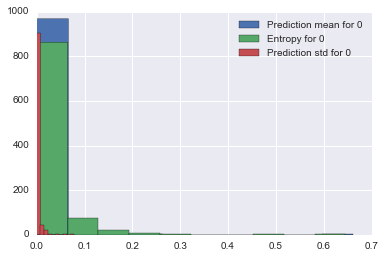

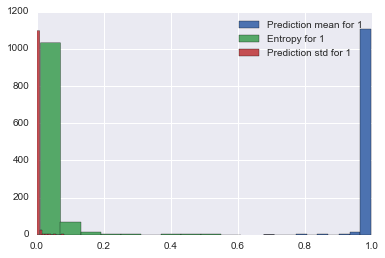

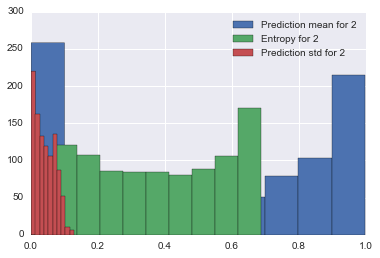

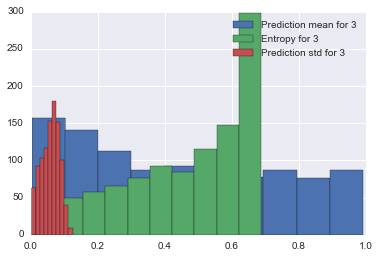

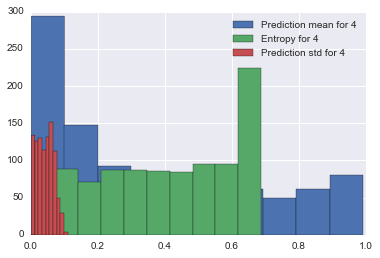

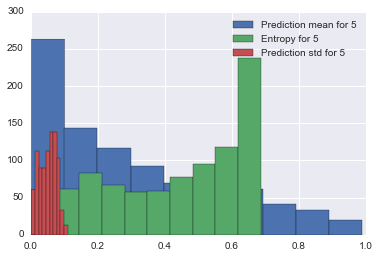

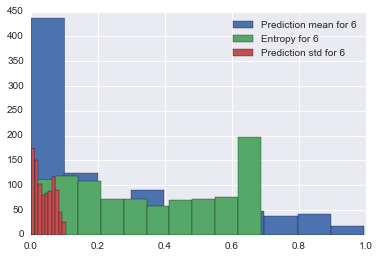

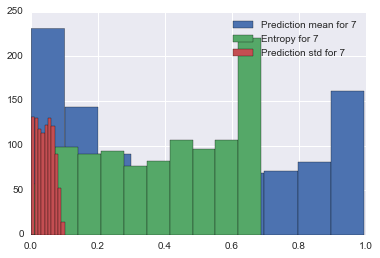

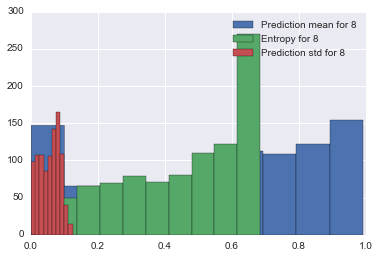

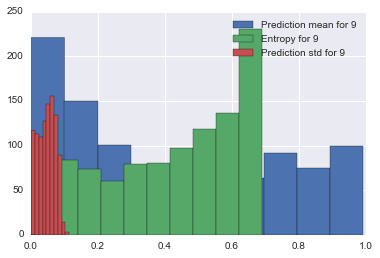

In [7]:
# Uncertainty prediction
test_pred_mean = {str(x):[] for x in range(0,10)}
test_pred_std = {str(x):[] for x in range(0,10)}
test_entropy_mean = {str(x):[] for x in range(0,10)}
print("Total test samples", len(X_test_all))
for i in range(len(X_test_all)):
    probs = test_prob(np.tile(X_test_all[i], posterior_samples).reshape(-1, n_in))
    entropy = test_entropy(np.tile(X_test_all[i], posterior_samples).reshape(-1, n_in))
    predictive_mean = np.mean(probs, axis=0)
    predictive_std = np.std(probs, axis=0)
    test_pred_mean[str(y_test_all[i])].append(predictive_mean[1])
    test_pred_std[str(y_test_all[i])].append(predictive_std[1])
    test_entropy_mean[str(y_test_all[i])].append(entropy.mean())

# Plotting
%matplotlib inline
for k in sorted(test_pred_mean.keys()):
    sns.plt.figure()
    sns.plt.hist(test_pred_mean[k], label = "Prediction mean for " + k)
    sns.plt.hist(test_entropy_mean[k], label = "Entropy for " + k)
    sns.plt.hist(test_pred_std[k], label = "Prediction std for " + k)
    sns.plt.legend()
    sns.plt.show()
    

In [8]:
# Anomaly detection
# by prediction entropy
entropy_threshold = np.linspace(0, 0.5, 1000)
entropy_acc = {}
for t in entropy_threshold:
    in_acc = 0.0
    out_acc = 0.0
    for l in test_entropy_mean:
        if l == '0' or l == '1':
            in_acc += (np.array(test_entropy_mean[l]) < t).mean()
        else:
            out_acc += (np.array(test_entropy_mean[l]) >= t).mean()
    in_acc /= 2.0
    out_acc /= 8.0
    bal_acc = (in_acc + out_acc)/2.0
    entropy_acc[bal_acc] = t
    
best_acc = sorted(entropy_acc, reverse=True)[0]
print("Entropy accuracy", best_acc, "Entropy threshold", entropy_acc[best_acc], )
    
# by prediction standard devition
std_threshold = np.linspace(0, 0.5, 1000)
std_acc = {}
for t in std_threshold:
    in_acc = 0.0
    out_acc = 0.0
    for l in test_pred_std:
        if l == '0' or l == '1':
            in_acc += (np.array(test_pred_std[l]) < t).mean()
        else:
            out_acc += (np.array(test_pred_std[l]) >= t).mean()
    in_acc /= 2.0
    out_acc /= 8.0
    bal_acc = (in_acc + out_acc)/2.0
    std_acc[bal_acc] = t
    
best_acc = sorted(std_acc, reverse=True)[0]
print("Std accuracy", best_acc, "Std threshold", std_acc[best_acc])
        

Entropy accuracy 0.926486418743 Entropy threshold 0.0865865865866
Std accuracy 0.932500517535 Std threshold 0.00700700700701
